In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
                    
                    #nrows=6000000)

In [4]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [5]:
train.shape

(629145480, 2)

In [6]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float64
dtypes: float64(1), int16(1)
memory usage: 5.9 GB


In [7]:
train.rename({"acoustic_data": "signal", "time_to_failure": "time"}, axis="columns", inplace=True)

In [8]:
train.head()

,signal,time
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


In [9]:
# Create a training file with simple derived features

rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','kurt','skew','median','var','sum','q1','q19','iqr','diff'\
                                'q2','Q1','q3','q4','Q2','q6','q7','Q3','q8','q81','q82','q9','q10','abs_mean',\
                                'hmean','gmean','time_to_failure'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['signal'].values
    y = seg['time'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = np.mean(x)
    X_train.loc[segment, 'std'] = np.std(x)
    X_train.loc[segment, 'max'] = np.max(x)
    X_train.loc[segment, 'min'] = np.min(x)
    X_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'skew'] = ((x-x.mean())/x.std() ** 3).mean()
    X_train.loc[segment,'kurt'] =  ((x-x.mean())/x.std() ** 4).mean()
    X_train.loc[segment, 'sum'] = np.sum(x)
    X_train.loc[segment, 'median'] = np.median(x)
    X_train.loc[segment, 'var'] = np.var(x)
    #X_train.loc[segment, 'exp'] = np(x)
    #X_train.loc[segment, 'log'] = ln(x)
    X_train.loc[segment, 'q1'] = np.quantile(x,.1)
    X_train.loc[segment, 'q19'] = np.quantile(x,.19)
    X_train.loc[segment, 'q2'] = np.quantile(x,.2)
    X_train.loc[segment, 'Q1'] = np.quantile(x,.25)
    X_train.loc[segment, 'q3'] = np.quantile(x,.3)
    X_train.loc[segment, 'q4'] = np.quantile(x,.4)
    X_train.loc[segment, 'Q2'] = np.quantile(x,.5)
    X_train.loc[segment, 'q6'] = np.quantile(x,.6)
    X_train.loc[segment, 'q7'] = np.quantile(x,.7)
    X_train.loc[segment, 'Q3'] = np.quantile(x,.75)
    X_train.loc[segment, 'q8'] = np.quantile(x,.8)
    X_train.loc[segment, 'q81'] = np.quantile(x,.81)
    X_train.loc[segment, 'q82'] = np.quantile(x,.82)
    X_train.loc[segment, 'q9'] = np.quantile(x,.9)
    X_train.loc[segment, 'q10'] = np.quantile(x,1) #81,82
    X_train.loc[segment, 'iqr'] = np.quantile(x,.75) - np.quantile (x,.25)
    #X_train.loc[segment, 'diff'] = np.max(x) - np.min (x)
   #X_train.loc[segment, 'hmean'] = stats.hmean(x)
    #X_train.loc[segment, 'gmean'] = stats.gmean(x)
    #X_train.loc[segment, 'abs_std'] = np.abs(x).std()
    #X_train.loc[segment, 'abs_min'] = np.abs(x).min()    
    #X_train.loc[segment, 'trend'] = add_trend_feature(x)
    #X_train.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)

100%|██████████| 4194/4194 [02:44<00:00, 24.36it/s]


In [10]:
X_train.head()

,ave,std,max,min,kurt,skew,median,var,sum,q1,q19,iqr,diffq2,Q1,q3,q4,Q2,q6,q7,Q3,q8,q81,q82,q9,q10,abs_mean,hmean,gmean,time_to_failure,q2
0,4.884113333333334,5.101089126891323,104.0,-98.0,-2.562764815176403e-19,-1.184237892933500e-18,5.0,26.021110280488884,732617.0,0.0,2.0,4.0,NaN,3.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,104.0,NaN,NaN,NaN,1.4307971859,2.0
1,4.725766666666667,6.588801819164257,181.0,-154.0,-1.279532035880493e-19,-7.005507285384737e-19,5.0,43.412309412222221,708865.0,0.0,2.0,5.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,181.0,NaN,NaN,NaN,1.3914988931,2.0
2,4.906393333333333,6.967373808828945,140.0,-106.0,1.391479524196863e-19,1.113183619357490e-18,5.0,48.544297791955557,735959.0,0.0,2.0,5.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,140.0,NaN,NaN,NaN,1.3531960947,2.0
3,4.902240000000000,6.922282112791032,197.0,-199.0,8.465450562766819e-20,4.884981308350689e-19,5.0,47.917989649066669,735336.0,0.0,2.0,5.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,197.0,NaN,NaN,NaN,1.3137978019,2.0
4,4.908720000000000,7.301085852684289,145.0,-126.0,9.737581111816477e-20,7.286763784956444e-19,5.0,53.305854628266673,736308.0,0.0,2.0,5.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,145.0,NaN,NaN,NaN,1.2743995091,2.0


In [13]:
from scipy import stats

#1
pearson_coef, p_value = stats.pearsonr(X_train['ave'], X_train['time_to_failure'])
print("ave: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#2
pearson_coef, p_value = stats.pearsonr(X_train['std'], X_train['time_to_failure'])
print("std: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#3

pearson_coef, p_value = stats.pearsonr(X_train['kurt'], X_train['time_to_failure'])
print("kurt: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#4
pearson_coef, p_value = stats.pearsonr(X_train['max'], X_train['time_to_failure'])
print("max: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#5
pearson_coef, p_value = stats.pearsonr(X_train['min'], X_train['time_to_failure'])
print("min: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#6
pearson_coef, p_value = stats.pearsonr(X_train['skew'], X_train['time_to_failure'])
print("skew: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#7
pearson_coef, p_value = stats.pearsonr(X_train['sum'], X_train['time_to_failure'])
print("sum: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#8
pearson_coef, p_value = stats.pearsonr(X_train['median'], X_train['time_to_failure'])
print("median: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#9
pearson_coef, p_value = stats.pearsonr(X_train['var'], X_train['time_to_failure'])
print("var: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#9
pearson_coef, p_value = stats.pearsonr(X_train['gmean'], X_train['time_to_failure'])
print("gmean: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)



ave: The Pearson Correlation Coefficient is -0.03131485200929432  with a P-value of P = 0.042572800232409745
std: The Pearson Correlation Coefficient is -0.217068826179775  with a P-value of P = 6.564514537505289e-46
kurt: The Pearson Correlation Coefficient is -0.03137478045305264  with a P-value of P = 0.04217798229575217
max: The Pearson Correlation Coefficient is -0.1896826701588192  with a P-value of P = 2.8493795430103317e-35
min: The Pearson Correlation Coefficient is 0.19408103734575255  with a P-value of P = 7.074292833901952e-37
skew: The Pearson Correlation Coefficient is -0.024760831194503785  with a P-value of P = 0.10886701222756817
sum: The Pearson Correlation Coefficient is -0.03131485200929434  with a P-value of P = 0.042572800232409745
median: The Pearson Correlation Coefficient is -0.0044450029567653  with a P-value of P = 0.7735159958650007
var: The Pearson Correlation Coefficient is -0.10517513939091518  with a P-value of P = 8.600345532359949e-12
gmean: The Pearso

In [14]:
#10
pearson_coef, p_value = stats.pearsonr(X_train['q1'], X_train['time_to_failure'])
print("q1: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#11
pearson_coef, p_value = stats.pearsonr(X_train['q19'], X_train['time_to_failure'])
print("q19: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#12
pearson_coef, p_value = stats.pearsonr(X_train['q2'], X_train['time_to_failure'])
print("q2: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#13
pearson_coef, p_value = stats.pearsonr(X_train['Q1'], X_train['time_to_failure'])
print("Q1: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#14
pearson_coef, p_value = stats.pearsonr(X_train['q3'], X_train['time_to_failure'])
print("q3: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#15
pearson_coef, p_value = stats.pearsonr(X_train['q4'], X_train['time_to_failure'])
print("q4: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#16
pearson_coef, p_value = stats.pearsonr(X_train['Q2'], X_train['time_to_failure'])
print("Q2: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#17
pearson_coef, p_value = stats.pearsonr(X_train['q6'], X_train['time_to_failure'])
print("q6: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#18
pearson_coef, p_value = stats.pearsonr(X_train['q7'], X_train['time_to_failure'])
print("q7: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#19
pearson_coef, p_value = stats.pearsonr(X_train['Q3'], X_train['time_to_failure'])
print("Q3: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#20
pearson_coef, p_value = stats.pearsonr(X_train['q8'], X_train['time_to_failure'])
print("q8: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#21
pearson_coef, p_value = stats.pearsonr(X_train['q81'], X_train['time_to_failure'])
print("q81: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#22
pearson_coef, p_value = stats.pearsonr(X_train['q82'], X_train['time_to_failure'])
print("q82: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#23
pearson_coef, p_value = stats.pearsonr(X_train['q9'], X_train['time_to_failure'])
print("q9: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#24
pearson_coef, p_value = stats.pearsonr(X_train['q10'], X_train['time_to_failure'])
print("q10: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

#25
pearson_coef, p_value = stats.pearsonr(X_train['iqr'], X_train['time_to_failure'])
print("iqr: The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

q1: The Pearson Correlation Coefficient is 0.45472936704789013  with a P-value of P = 3.656259962449344e-213
q19: The Pearson Correlation Coefficient is 0.46569147449333415  with a P-value of P = 7.937636347791565e-225
q2: The Pearson Correlation Coefficient is 0.45261129991855875  with a P-value of P = 5.858858295270717e-211
Q1: The Pearson Correlation Coefficient is 0.3588626305135062  with a P-value of P = 1.0978135212546844e-127
q3: The Pearson Correlation Coefficient is 0.2834822256248399  with a P-value of P = 2.3870961725134474e-78
q4: The Pearson Correlation Coefficient is 0.13836657148635756  with a P-value of P = 2.2280069420992113e-19
Q2: The Pearson Correlation Coefficient is -0.0044450029567653  with a P-value of P = 0.7735159958650007
q6: The Pearson Correlation Coefficient is -0.1695744241759776  with a P-value of P = 1.9889094673043306e-28
q7: The Pearson Correlation Coefficient is -0.3338120112434793  with a P-value of P = 1.055846088709528e-109
Q3: The Pearson Correla

In [15]:
#X_train['std'].unique

In [16]:
#X_train['time_to_failure'].unique
X_train['time_to_failure'].describe()

count    4194.000000000000000
mean        5.682698488340905
std         3.673144820066522
min         0.006397657167800
25%         2.634173052750000
50%         5.354846515149999
75%         8.175924278749999
max        16.103195567000000
Name: time_to_failure, dtype: float64

In [17]:
#X_train=X_train[X_train['ave']<=5.20555]

In [18]:
# Creating a cloumn featuring binary values on the basis of accident risks
X_train['outcome'] =[1 if x<=5.682698488340905 else 0 for x in X_train['time_to_failure']]

In [19]:
X_train.head(2)

,ave,std,max,min,kurt,skew,median,var,sum,q1,q19,iqr,diffq2,Q1,q3,q4,Q2,q6,q7,Q3,q8,q81,q82,q9,q10,abs_mean,hmean,gmean,time_to_failure,q2,outcome
0,4.884113333333334,5.101089126891323,104.0,-98.0,-2.562764815176403e-19,-1.184237892933500e-18,5.0,26.021110280488884,732617.0,0.0,2.0,4.0,NaN,3.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,104.0,NaN,NaN,NaN,1.4307971859,2.0,1
1,4.725766666666667,6.588801819164257,181.0,-154.0,-1.279532035880493e-19,-7.005507285384737e-19,5.0,43.412309412222221,708865.0,0.0,2.0,5.0,NaN,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,181.0,NaN,NaN,NaN,1.3914988931,2.0,1


In [20]:
#x_train=X_train [['diff','ave', 'std', 'max', 'min','kurt','skew','median','var','sum','q1','q19','abs_mean',\
                               # 'q2','Q1','q3','q4','Q2','q6','q7','Q3','q8','q81','q82','q9','q10','iqr']]#=2.065
x_train=X_train [['q1','q19','q2','Q1','q3','q4','Q2','q6','q7','Q3','q8','q81','q82','q9','q10','iqr']]#=2.062
#x_train=X_train [['q1','q19','q2','q8','q81','q82','q9','min','max','std','iqr']]#=2.075
#x_train=X_train [['q1','q19','q2','q8','q81','q82','q9','iqr']] # = 2.075
x_train.head()

,q1,q19,q2,Q1,q3,q4,Q2,q6,q7,Q3,q8,q81,q82,q9,q10,iqr
0,0.0,2.0,2.0,3.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,104.0,4.0
1,0.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,181.0,5.0
2,0.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,140.0,5.0
3,0.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,197.0,5.0
4,0.0,2.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,8.0,10.0,145.0,5.0


In [21]:
x_train.isnull().sum()

q1     0
q19    0
q2     0
Q1     0
q3     0
q4     0
Q2     0
q6     0
q7     0
Q3     0
q8     0
q81    0
q82    0
q9     0
q10    0
iqr    0
dtype: int64

In [22]:
x_train.shape

(4194, 16)

In [23]:
#y_train.head()
y_train=X_train[['outcome']]
y_train.head()

,outcome
0,1
1,1
2,1
3,1
4,1


In [24]:
y_train.shape

(4194, 1)

In [25]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train_scaled = scaler.transform(x_train)

In [26]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

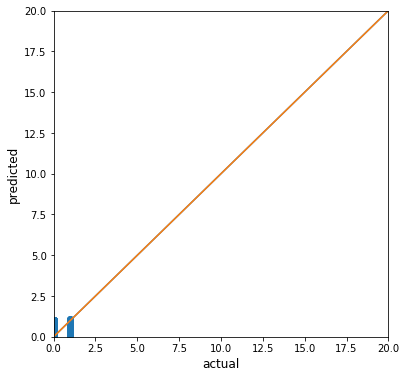

In [27]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


In [28]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 0.208


In [29]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')

In [30]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [31]:
#X_train=X_train.drop(['time_to_failure'], axis=1)

In [32]:
X_test = pd.DataFrame(columns=x_train.columns, dtype=np.float64, index=submission.index)

In [33]:
X_test.shape

(2624, 16)

In [34]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    #X_test.loc[seg_id, 'ave'] = x.mean()
    #X_test.loc[seg_id, 'std'] = np.std(x)
    #X_test.loc[seg_id, 'max'] = np.max(x)
    #X_test.loc[seg_id, 'min'] = np.min(x)
    #X_test.loc[seg_id, 'kurt'] = ((x-x.mean())/x.std() ** 4).mean()
    #X_test.loc[seg_id, 'skew'] = ((x-x.mean())/x.std() ** 3).mean()
    #X_test.loc[seg_id, 'sum'] = x.sum()
    X_test.loc[seg_id, 'q1'] = np.quantile(x,.1)
    X_test.loc[seg_id, 'q19'] = np.quantile(x,.19)
    X_test.loc[seg_id, 'q2'] = np.quantile(x,.2)
    X_test.loc[seg_id, 'Q1'] = np.quantile(x,.25)
    X_test.loc[seg_id, 'q3'] = np.quantile(x,.3)
    X_test.loc[seg_id, 'q4'] = np.quantile(x,.4)
    X_test.loc[seg_id, 'Q2'] = np.quantile(x,.5)
    X_test.loc[seg_id, 'q6'] = np.quantile(x,.6)
    X_test.loc[seg_id, 'q7'] = np.quantile(x,.7)
    X_test.loc[seg_id, 'Q3'] = np.quantile(x,.75)
    X_test.loc[seg_id, 'q8'] = np.quantile(x,.8)
    X_test.loc[seg_id, 'q81'] = np.quantile(x,.81)
    X_test.loc[seg_id, 'q82'] = np.quantile(x,.82)
    X_test.loc[seg_id, 'q9'] = np.quantile(x,.9)
    X_test.loc[seg_id, 'q10'] = np.quantile(x,1)
    X_test.loc[seg_id, 'iqr'] = np.quantile(x,.75) - np.quantile (x,.25)

In [35]:
X_test.shape

(2624, 16)

In [36]:
X_test.head()

,q1,q19,q2,Q1,q3,q4,Q2,q6,q7,Q3,q8,q81,q82,q9,q10,iqr
seg_id,,,,,,,,,,,,,,,,
seg_00030f,0.0,1.0,1.0,2.0,3.0,4.0,4.0,5.0,6.0,7.0,7.0,8.0,8.0,9.0,115.0,5.0
seg_0012b5,-1.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0,6.0,7.0,7.0,7.0,7.0,9.0,152.0,5.0
seg_00184e,0.0,2.0,2.0,2.0,3.0,4.0,5.0,5.0,6.0,7.0,7.0,8.0,8.0,9.0,248.0,5.0
seg_003339,1.0,2.0,2.0,3.0,3.0,4.0,5.0,5.0,6.0,7.0,7.0,7.0,7.0,8.0,85.0,4.0
seg_0042cc,0.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0,6.0,6.0,7.0,7.0,7.0,9.0,177.0,4.0


In [37]:
X_test.isnull().sum()

q1     0
q19    0
q2     0
Q1     0
q3     0
q4     0
Q2     0
q6     0
q7     0
Q3     0
q8     0
q81    0
q82    0
q9     0
q10    0
iqr    0
dtype: int64

In [38]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')